# 6d reconstruction scan

In [24]:
import os
import sys
sys.path.append("../")

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


## define the diagnostic

In [25]:
from measurement import get_DYG14, get_DYG15, set_camera, set_background

save_image_location = "/home/awa/awa_data/01_19_6DReconstruction/reconstruction_scan"
DYG14 = get_DYG14()
DYG15 = get_DYG15()

DYG14.save_image_location = save_image_location
DYG15.save_image_location = save_image_location
DYG14.background_file = save_image_location + "/DYG14_background.npy"
DYG15.background_file = save_image_location + "/DYG15_background.npy"


In [31]:
#DYG15.target_charge = None
#DYG15.test_measurement()
set_camera(DYG15)


setting camera DYG15
192.168.2.111
setting IP address 192.168.2.139
setting gain
starting acquisition


setting camera DYG15
192.168.2.139
ip address already set
starting acquisition
please shutter beam


please un-shutter beam


background file: /home/awa/awa_data/01_19_6DReconstruction/reconstruction_scan/DYG15_background.npy
measured charge:  8.40718375824537e-09
charge error 1.6e-09 outside atol 1e-09
measured charge:  9.457855046570146e-09
displaying image
fitting image
measured charge:  9.826947929565683e-09
displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 230.8531219175344,
 'total_intensity': 571466041.6000001,
 'log10_total_intensity': 8.756990428285262,
 'AWAVXI11ICT:Ch1': 9.826947929565683e-09}

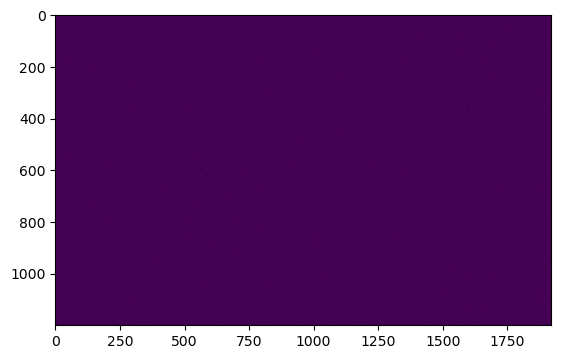

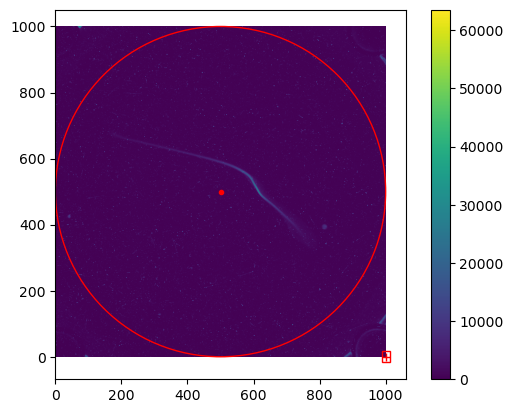

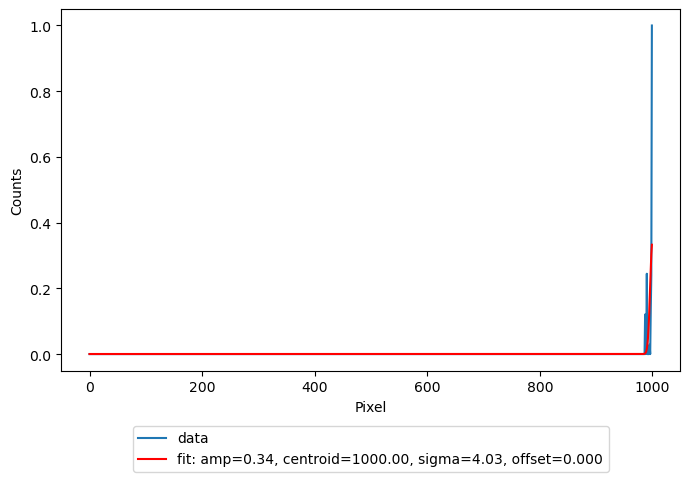

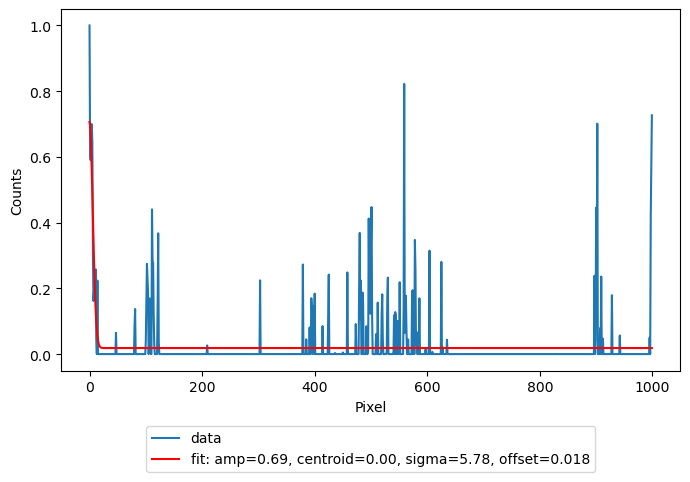

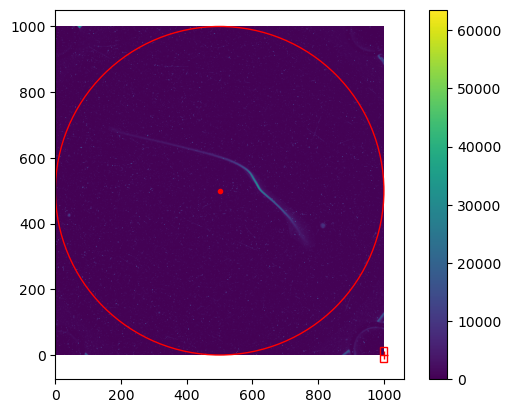

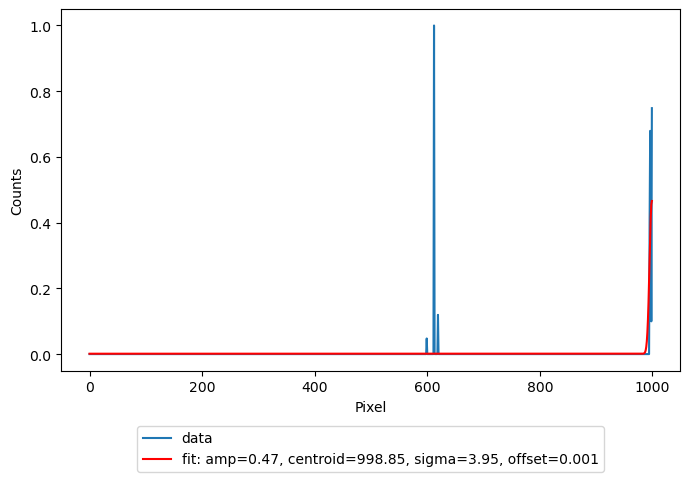

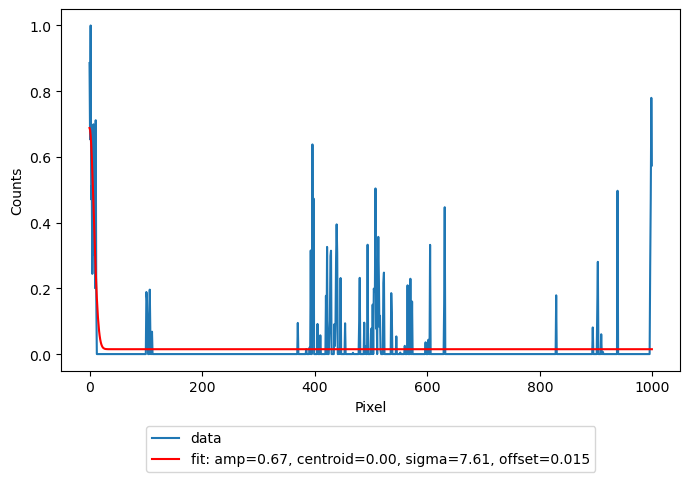

In [29]:

DYG15.target_charge_pv="AWAVXI11ICT:Ch1"
DYG15.target_charge = 10.0e-9
DYG15.charge_atol = 1.0e-9
DYG15.roi.xwidth = 1000
DYG15.roi.ywidth = 1000

set_background(DYG15)


DYG15.test_measurement()

In [30]:
DYG15.visualize = False
DYG15.measure_beamsize(20, fit_image=True)

measured charge:  9.964271491422415e-09
fitting image
measured charge:  9.289886445035328e-09
fitting image
measured charge:  1.2850438810933338e-08
charge error 2.9e-09 outside atol 1e-09
measured charge:  9.91490583081527e-09
fitting image
measured charge:  9.90213338718871e-09
fitting image
measured charge:  1.0227408835389352e-08
fitting image
measured charge:  1.018309814527759e-08
fitting image
measured charge:  8.676511343479958e-09
charge error 1.3e-09 outside atol 1e-09
measured charge:  1.1039612915177837e-08
charge error 1e-09 outside atol 1e-09
measured charge:  1.057406646719589e-08
fitting image
measured charge:  8.606945861794946e-09
charge error 1.4e-09 outside atol 1e-09
measured charge:  1.024157246587428e-08
fitting image
measured charge:  9.109399087688588e-09
fitting image
measured charge:  9.935737589965422e-09
fitting image
measured charge:  1.2511022385262374e-08
charge error 2.5e-09 outside atol 1e-09
measured charge:  1.0668296784560075e-08
fitting image
measu

{'Cx': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Cy': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Sx': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Sy': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'bb_penalty': [228.16928568457342,
  231.5697002880812,
  230.4826556589918,
  232.7370709527462,
  228.8517681111398,
  230.80954049336674,
  228.3941571466745,
  238.4257109235483,
  239.27934191973088,
  232.64436930140994,
  226.86011128001383,
  229.12356740635346,
  232.62831293005308,
  226.8850129514152,
  227.8555586551803,
  230.56209016826767,
  231.86650009918094,
  226.5220598715323,
  225.46965

In [ ]:
DYG14

In [ ]:
set_camera(DYG15)
set_background(DYG14, skip_test_measurement=True)
set_background(DYG15, skip_test_measurement=True)

### Define the evaluator

In [ ]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

def evaluate_function(inputs: dict, diagnostic, testing=False) -> dict:
    # caput values
    if not testing:
        for name, val in inputs.items():
            caput(name, val)
            print(name, val)

    # wait for changes to occur
    time.sleep(2)
    print(time.time())
    results = diagnostic.measure_beamsize(5, fit_image=False, **inputs)

    return results | inputs

evaluator = Evaluator(function=evaluate_function)

### Set up scan

In [ ]:
# quad strength pv values
import numpy as np
import pandas as pd
import yaml
import json

x = np.linspace(-0.4,0.4,3)
quad_pv_name = "AWA:Bira3Ctrl:Ch10"
tdc_pv_name = "pi:QBCR1:Ch7:EnablePulse"
dipole_pv_name = "AWA:Bira4Ctrl:Ch01"
tdc_vals = {"OFF":0, "ON":1} # off/on values
dipole_vals = {"OFF":0, "ON":-3.64} # off/on vals

DYG14.target_charge = 4.5e-9
DYG15.target_charge = 4.5e-9
DYG14.charge_atol = 0.5e-9
DYG15.charge_atol = 0.5e-9
DYG14.wait_time = 0.6
DYG15.wait_time = 0.6


def do_quad_scan(k, pv_dict, diagnostic, testing=False):
    q_scan_data = []
    print("doing quad scan")
    for ele in k:
        # add tcav/dipole settings to quad settings
        total_pvs = pv_dict | {quad_pv_name:ele}
        print(total_pvs)

        # do measurement
        result = evaluate_function(total_pvs, diagnostic, testing)
        q_scan_data += [result]

    return q_scan_data

data = []

# do quad scan with dipole off
set_camera(DYG14)
# set dipole
print("setting dipole")
caput(dipole_pv_name, dipole_vals["OFF"])
time.sleep(15)
print("dipole finished moving")
for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["OFF"]},
        DYG14,
    )
    data = data + q_scan_results

    pd_data = pd.DataFrame(data)

    # save dataframe to file
    with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
        yaml.dump(json.loads(pd_data.to_json(orient="records"))
    , outfile, default_flow_style=False)





# do quad scan with dipole on
set_camera(DYG15)
# set dipole
print("setting dipole")
caput(dipole_pv_name, dipole_vals["OFF"])
time.sleep(15)
print("dipole finished moving")

for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["ON"]},
        DYG15,
    )
    data = data + q_scan_results

    pd_data = pd.DataFrame(data)

    # save dataframe to file
    with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
        yaml.dump(json.loads(pd_data.to_json(orient="records"))
    , outfile, default_flow_style=False)

pd_data = pd.DataFrame(data)

# save dataframe to file
with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
    yaml.dump(json.loads(pd_data.to_json(orient="records"))
, outfile, default_flow_style=False)

In [ ]:
import yaml
import json

